In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_color_codes('deep')

from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.figsize'] = (8, 6)

meanprops = {'marker':'o',
             'markerfacecolor':'white', 
             'markeredgecolor':'black',
             'markeredgewidth': 1.5,
             'markersize':'10'}

# Clustering using RFMSA segmentation

In [9]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

In [10]:
df_rfmsa = pd.read_csv('./data/df_rfmsa.csv', index_col=0)
X_rfmsa = df_rfmsa.copy()

In [11]:
n_clust = 6

# We define a pipeline in which we will normalize the data then apply clustering with KMeans
model = make_pipeline(StandardScaler(), KMeans(n_clusters=n_clust, random_state=12))
model.fit(X_rfmsa)

clusters = model['kmeans'].labels_
np.unique(clusters)

array([0, 1, 2, 3, 4, 5], dtype=int32)

Visualizing clusters using box plots

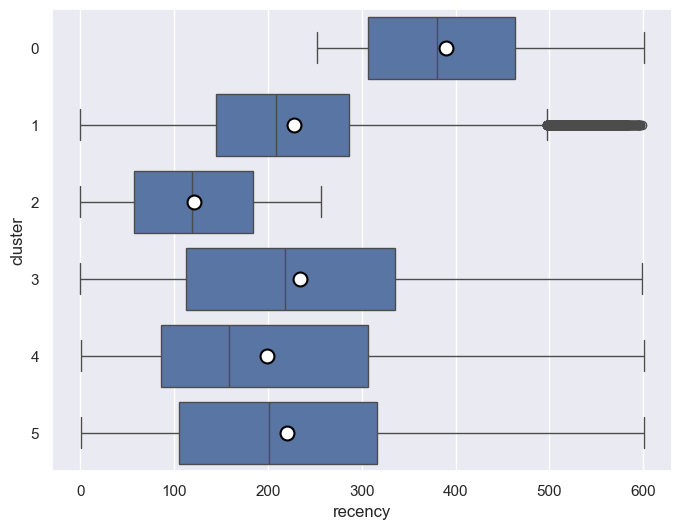

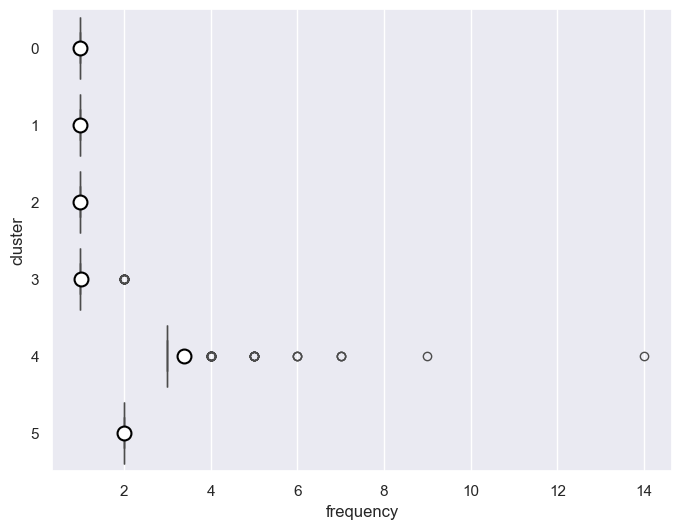

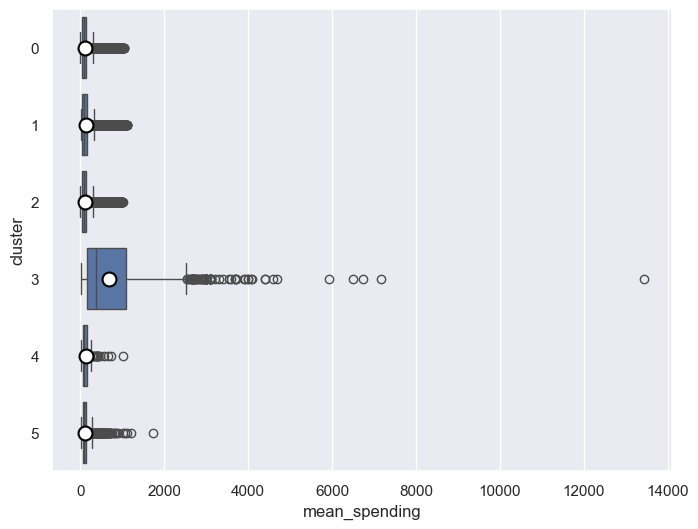

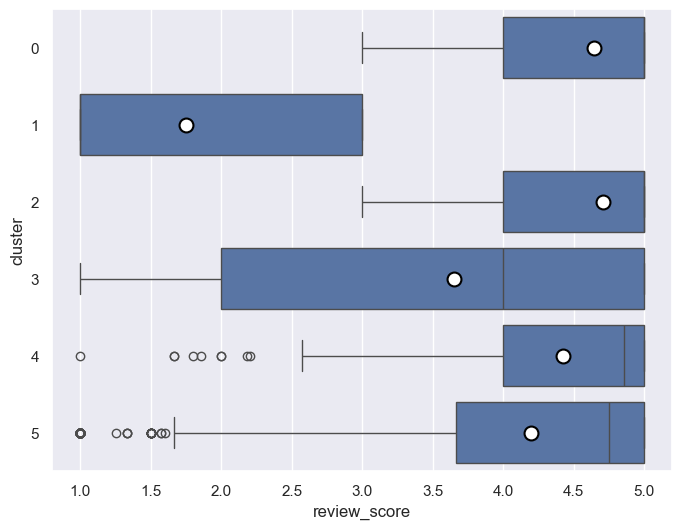

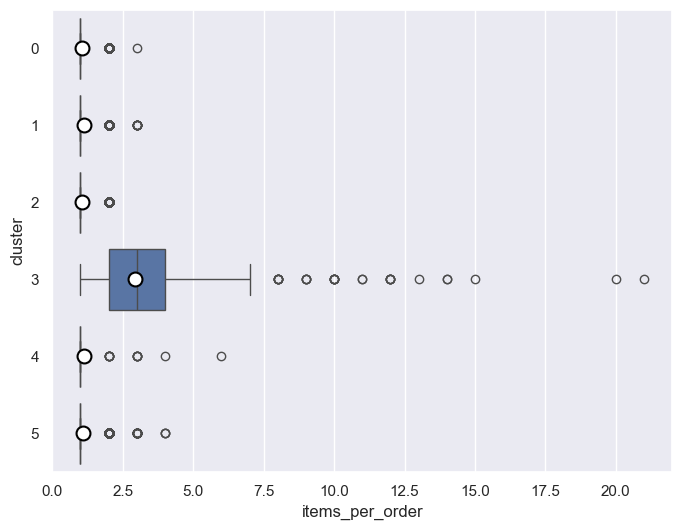

In [12]:
df_rfmsa['cluster'] = clusters

for col in df_rfmsa.columns[:-1]:
    plt.figure(figsize=(8,6))
    sns.boxplot(x=col, y='cluster', data=df_rfmsa, orient='h', showfliers=True, showmeans=True,
               meanprops=meanprops)

# Maintenance time estimation

To estimate the maintenance delay, we will compare the clustering obtained by a model initialized at a date $T_0$ with that obtained by a model initialized at a later date $T_1$. To compare the two clusterings, we will use the ARI (Adjusted Rand Score), whose value is between 0 and 1. We will set a threshold of 0.8 to judge the similarity between the clusterings; when we go below this threshold, a reinitialization of the model is required.

In [13]:
from sklearn.metrics.cluster import adjusted_rand_score

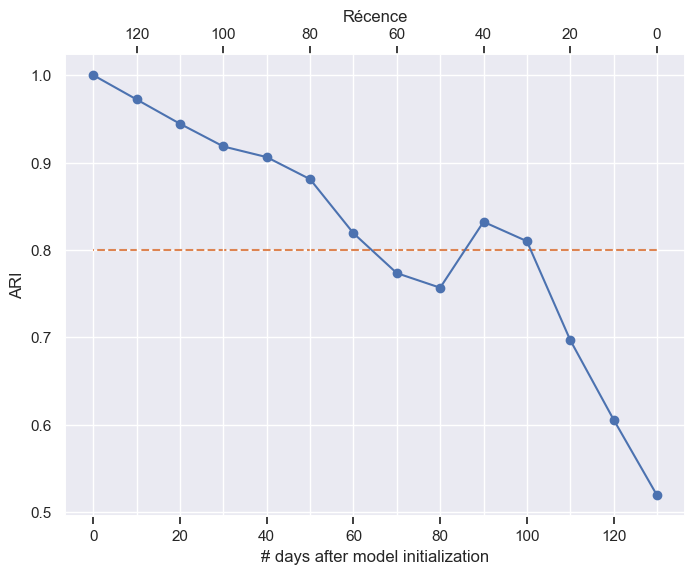

In [ ]:
recence_init = 130
days_range = recence_init
days_step = 10
threshold = .8

X_0 = X_rfmsa[X_rfmsa['recency'] > recence_init].copy()

model_init = make_pipeline(StandardScaler(), KMeans(n_clusters=n_clust, random_state=12))
model_init.fit(X_0)

ari = []

# We will add all the commands that took place during 'days_range' since 'recence_init' by taking 'days_step' steps and at
# each step we will compare the clustering obtained by the old model (model_init) with that obtained by the new model 
# (model_new) using ARI.
n_days = np.arange(0, days_range+1, days_step)
for n in n_days:
    X_1 = X_rfmsa[X_rfmsa['recency'] > recence_init - n].copy()

    clusters_init = model_init.predict(X_1)

    model_new = make_pipeline(StandardScaler(), KMeans(n_clusters=n_clust, random_state=12))
    model_new.fit(X_1)
    clusters_new = model_new['kmeans'].labels_

    ari += [adjusted_rand_score(labels_true=clusters_new, labels_pred=clusters_init)]

ari = np.array(ari)

# Plot results
delta = recence_init - days_range
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(n_days[::-1]+delta, np.zeros(n_days.shape)+threshold, '--', color='#dd8452')
ax.set_xlabel('# days after model initialization')
ax.set_ylabel('ARI')

ax2 = ax.twiny()
ax2.plot(n_days[::-1]+delta, ari, 'o-')
ax2.set_xlabel('Recency (days)')
ax2.invert_xaxis()

plt.show()